# ECG Data Classification

This notebook uses a baic CNN model to classify the ECG time-series data

In [1]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report
import tensorflow as tf

# Pre-processing

In [2]:
def reshape_dataset(X,Y):
  x_arr=(np.asarray(X))
  x_reshape = x_arr.reshape((x_arr.shape[0], x_arr.shape[1], 1))
  Y=list(map(int,Y))
  y_arr=np.asarray(Y)
  y_reshape=y_arr.reshape((y_arr.shape[0]),1)
  print(x_reshape.shape)
  print(y_reshape.shape)
  return x_reshape,y_reshape

In [18]:
from sklearn.utils import resample
train_data=pd.read_csv('/content/drive/MyDrive/Git Project/mitbih_train.csv',header=None)
train_data=train_data.dropna()
c1=train_data[train_data[187]==1]
c2=train_data[train_data[187]==2]
c3=train_data[train_data[187]==3]
c4=train_data[train_data[187]==4]
c5=(train_data[train_data[187]==0]).sample(n=10000)

train_data=pd.concat([c1,c2,c3,c4,c5])
X_train=train_data.iloc[:,5:]
Y_train=train_data[187]
x_train,y_train=reshape_dataset(X_train,Y_train)


(25083, 183, 1)
(25083, 1)


In [20]:
y_train

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]])

# Training

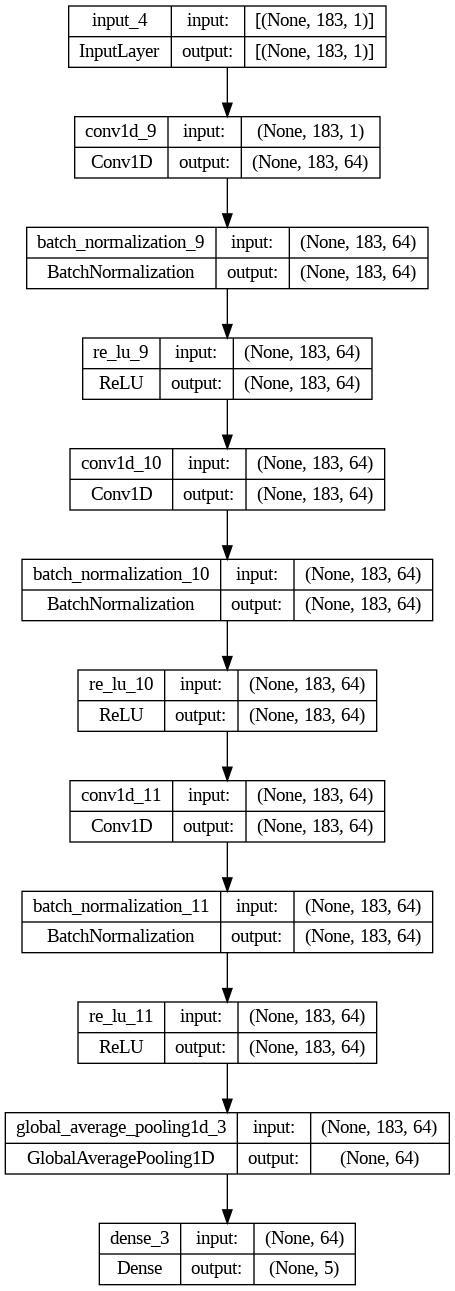

In [21]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(5, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=x_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

In [22]:
epochs = 20
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "CNN.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/20
628/628 [==============================] - 24s 36ms/step - loss: 0.7907 - sparse_categorical_accuracy: 0.7597 - val_loss: 0.4947 - val_sparse_categorical_accuracy: 0.8908 - lr: 0.0010
Epoch 2/20
628/628 [==============================] - 22s 34ms/step - loss: 0.3122 - sparse_categorical_accuracy: 0.9251 - val_loss: 0.2824 - val_sparse_categorical_accuracy: 0.8983 - lr: 0.0010
Epoch 3/20
628/628 [==============================] - 21s 34ms/step - loss: 0.1352 - sparse_categorical_accuracy: 0.9767 - val_loss: 16.1546 - val_sparse_categorical_accuracy: 0.0245 - lr: 0.0010
Epoch 4/20
628/628 [==============================] - 24s 38ms/step - loss: 0.0734 - sparse_categorical_accuracy: 0.9900 - val_loss: 19.5617 - val_sparse_categorical_accuracy: 0.0153 - lr: 0.0010
Epoch 5/20
628/628 [==============================] - 20s 33ms/step - loss: 0.1236 - sparse_categorical_accuracy: 0.9754 - val_loss: 2.9054 - val_sparse_categorical_accuracy: 0.1226 - lr: 0.0010
Epoch 6/20
628/628 [===

# Evaluation and Testing

In [23]:
test_data=pd.read_csv('/content/drive/MyDrive/Git Project/mitbih_test.csv',header=None)
test_data=test_data.dropna()

X_test=test_data.iloc[:,5:]
Y_test=test_data[187]
x_test,y_test=reshape_dataset(X_test,Y_test)


model.evaluate(x_test,y_test)
y_pred=model.predict(x_test)



(21892, 183, 1)
(21892, 1)
685/685 [==============================] - 7s 9ms/step


In [24]:
def CM(labels,pred,names):
  
  confusionmat=confusion_matrix(labels,pred,labels=names)
  fig, ax = plt.subplots(figsize=(15,15))
  disp = ConfusionMatrixDisplay(confusion_matrix=confusionmat,display_labels=names)
  disp.plot(ax=ax) 
  cf=classification_report(labels,pred,labels=names)
  print(cf)
  

# Metrics

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18118
           1       1.00      1.00      1.00       556
           2       1.00      1.00      1.00      1448
           3       1.00      0.93      0.96       162
           4       0.99      1.00      1.00      1608

    accuracy                           1.00     21892
   macro avg       1.00      0.99      0.99     21892
weighted avg       1.00      1.00      1.00     21892



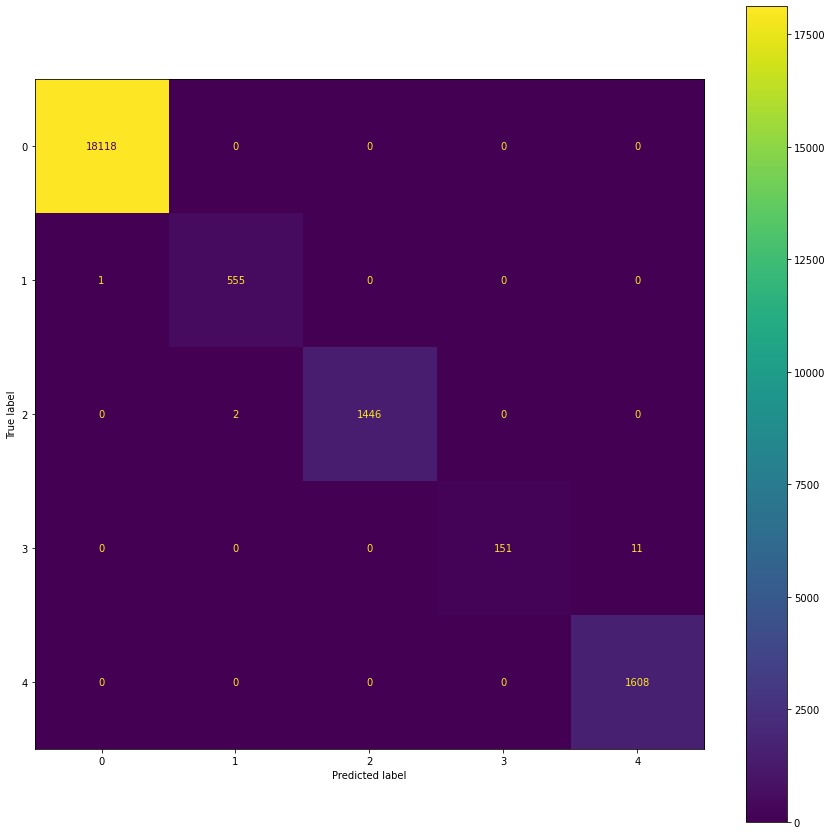

In [25]:
pred_classes = [np.argmax(i) for i in y_pred]
labels=list(map(int,Y_test))
CM(labels,pred_classes,[0,1,2,3,4])